In [1]:
import json
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from tensorflow.keras.layers import Flatten

In [2]:
# Load the dictionary from the JSON file
json_file = 'data&labels.json'
with open(json_file, 'r') as f:
    image_dict = json.load(f)

# Extract paths and labels, ensuring they are aligned
image_paths, labels = zip(*image_dict.items())

# Load images and resize them
images = []
for path in image_paths:
    img = cv2.imread(path)
    img = cv2.resize(img, (100, 100))  # Resize to 100x100
    images.append(img)

images = np.array(images)

# Encode labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

In [8]:
# Load the VGG16 model
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(100, 100, 3))

# Extract features using the VGG16 model
features = vgg_model.predict(preprocess_input(images.copy()))
features = features.reshape(features.shape[0], -1)

# Split the data into training and test sets
X_train, X_test, y_train, y_test, paths_train, paths_test = train_test_split(
    features, encoded_labels, image_paths, test_size=0.3, random_state=42, stratify=encoded_labels)

33/33 [==============================] - 17s 501ms/step


In [9]:
# Logistic Regression Model
logreg = LogisticRegression(max_iter=3000)
param_grid = {'C': [0.0001]}
grid_search = GridSearchCV(logreg, param_grid, cv=5)
grid_search.fit(X_train, encoded_y_train)
accuracy = grid_search.score(X_test, encoded_y_test)
print("Accuracy:", accuracy)

Accuracy: 0.8187702265372169


In [10]:
# Predict labels for the test set
y_pred = grid_search.predict(X_test)

# Find indices of correctly and incorrectly labeled images
correct_indices = [i for i, (pred, actual) in enumerate(zip(y_pred, y_test)) if pred == actual]
incorrect_indices = [i for i, (pred, actual) in enumerate(zip(y_pred, y_test)) if pred != actual]

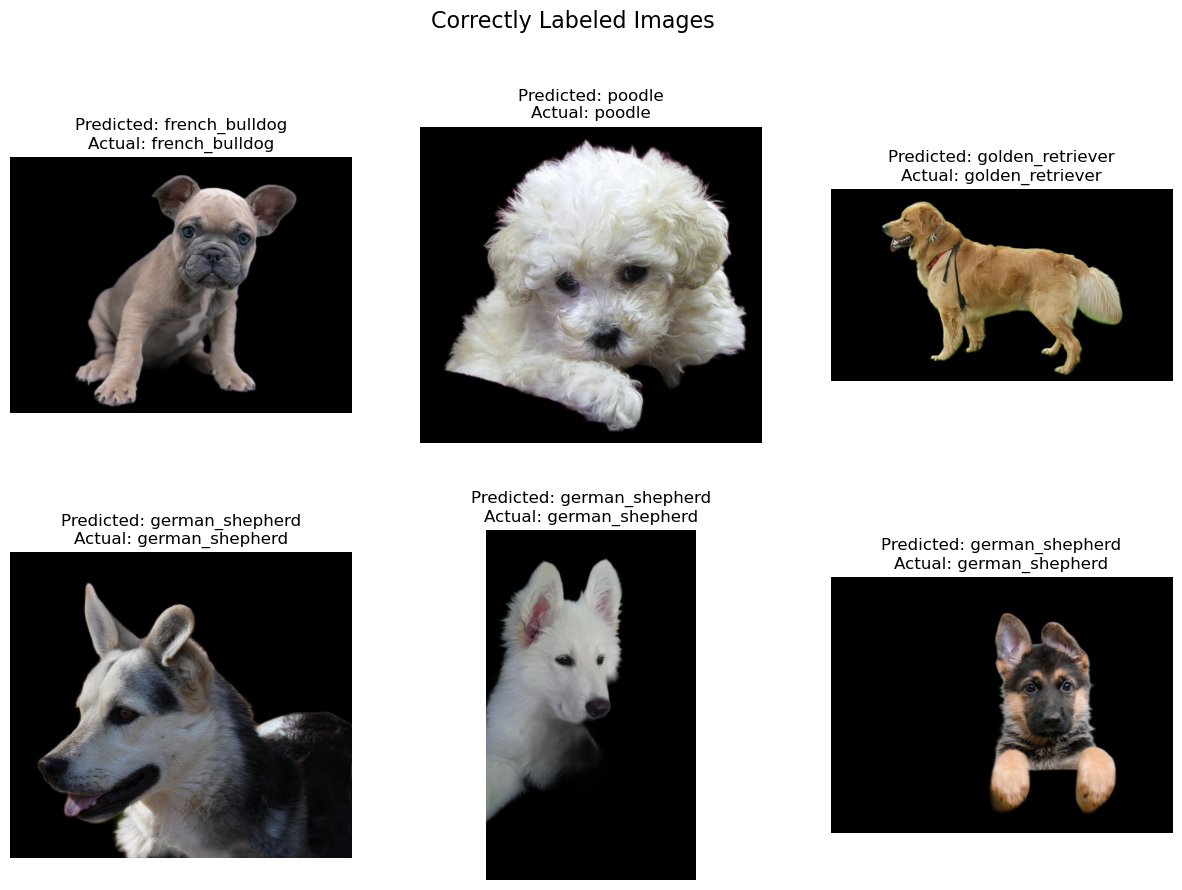

In [11]:
# Function to plot images
def plot_images(indices, title):
    plt.figure(figsize=(15, 10))
    plt.suptitle(title, fontsize=16)
    for i, idx in enumerate(indices[:6]):
        img = cv2.imread(paths_test[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(2, 3, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Predicted: {label_encoder.inverse_transform([y_pred[idx]])[0]}\n" +
                  f"Actual: {label_encoder.inverse_transform([y_test[idx]])[0]}")
    plt.show()

# Display some correctly labeled images
plot_images(correct_indices, 'Correctly Labeled Images')

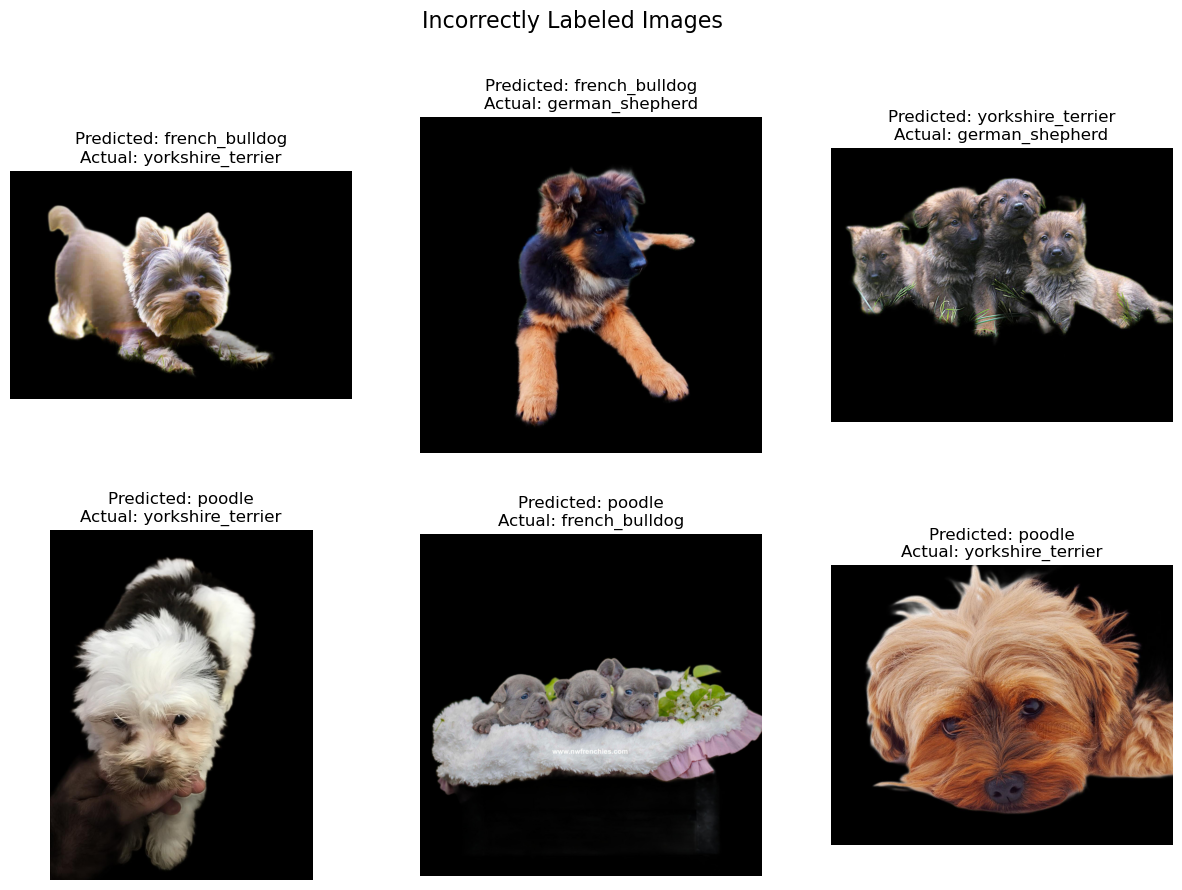

In [12]:
# Display some incorrectly labeled images
plot_images(incorrect_indices, 'Incorrectly Labeled Images')